#**Transfer Learning with EfficientNetV2B3 on Stanford Dogs Dataset**
 This notebook demonstrates how to perform transfer learning using the EfficientNetV2B3 architecture for image classification tasks on the Stanford Dogs dataset. Transfer learning involves leveraging pre-trained models on large datasets (e.g., ImageNet) and fine-tuning them on a specific task using a smaller dataset.

In [1]:
import tensorflow as tf

## Importing and splitting data

In [2]:
# Get TensorFlow Datasets
import tensorflow_datasets as tfds

# Load in the data
(train_data, test_data), ds_info = tfds.load(name="stanford_dogs",
                                             split=["train", 'test'],
                                             shuffle_files=True,
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/12000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteLB77K8/stanford_dogs-train.tfrecord*...:   0…

Generating test examples...:   0%|          | 0/8580 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteLB77K8/stanford_dogs-test.tfrecord*...:   0%…

Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


## Visualizing data

In [3]:
ds_info.features
# Get the total number of training samples
num_train_samples = tf.data.experimental.cardinality(train_data).numpy()

print("Total number of training samples:", num_train_samples)
# Get the total number of test samples
num_test_samples = tf.data.experimental.cardinality(test_data).numpy()

print("Total number of test samples:", num_test_samples)

Total number of training samples: 12000
Total number of test samples: 8580


In [4]:
class_names = ds_info.features['label'].names
for i in range(len(class_names)):
    # Update each class name by removing the first 10 characters
    class_names[i] = class_names[i][10:]


    Image shape: (1879, 1388, 3)
    Image dtype: <dtype: 'uint8'>
    Target class from StanfordDogs (tensor form): 63
    Class name (str form): gordon_setter
    


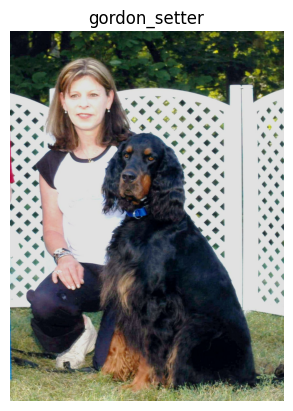

In [5]:
import matplotlib.pyplot as plt

# Visualize one image
train_data_one_sample = train_data.take(1)

# Output info about the training sample
for image, label in train_data_one_sample:
    print(f"""
    Image shape: {image.shape}
    Image dtype: {image.dtype}
    Target class from StanfordDogs (tensor form): {label}
    Class name (str form): {class_names[label.numpy()]}
    """)

    plt.imshow(image)
    plt.title(class_names[label.numpy()])
    plt.axis('off')
    plt.show()

# Preprocessing

In [6]:
def preprocess_image(image, label, IMG_SHAPE=224):
    # Resize to target shape
    image = tf.image.resize(image, [IMG_SHAPE, IMG_SHAPE])
    # Convert to float32
    image = tf.cast(image, dtype=tf.float32)
    return image, label

In [7]:
# Map preprocessing function to training data (and parallelize)
train_data = train_data.map(map_func=preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

# Define Callbacks

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Define callbacks
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.h5',
                                      monitor='val_loss',
                                      save_best_only=True,
                                      verbose=1)
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        patience=3,
                                        verbose=1,
                                        restore_best_weights=True)

# Model Architecture

The model architecture consists of the following components:

1. **Input Layer**:
   - The input layer (input_layer) expects input tensors of shape (None, 224, 224, 3).
   - The 'None' dimension indicates a variable batch size, and '3' represents the number of color channels (RGB).

3. **Base Model**:
   - The efficientnetv2b3 layer is the EfficientNetV2B3 base model pre-trained on ImageNet.
   - It produces feature maps with shape (None, None, None, 1536).
   - The last layers of the base model have been unfrozen for fine-tuning.

4. **Global Average Pooling**:
   - The global_average_pooling2d layer computes the average of each feature map across spatial dimensions.
   - This results in a global average pooled feature vector with shape (None, 1536).

5. **Dense Layer**:
   - The dense layer consists of 128 neurons with the ReLU activation function.
   - Dense layers are used for feature extraction and transformation.
   - The dense layer helps in learning higher-level features by combining the outputs of the previous layers.
6. **Dropout Layer**:
   - The dropout layer applies dropout regularization with a dropout rate of 0.3.
   - It randomly sets 30% of input units to 0 during training to prevent overfitting.

7. **Output Layer**:
   - The output_layer is a dense layer with 120 neurons, corresponding to the number of classes in the Stanford Dogs dataset.
   - It uses the softmax activation function to produce class probabilities.

In [9]:
from tensorflow.keras import layers

# Base model for transfer learning
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B3(include_top=False, weights='imagenet')
base_model.trainable = False
input_shape = (224, 224, 3)
for layer in base_model.layers[-10:]:
  layer.trainable = True

# Functional modeling
inputs = layers.Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax', name='output_layer')(x)
model = tf.keras.Model(inputs, outputs)

52606240/52606240 [==============================] - 3s 0us/step


#Model Compilation
The model is compiled using the following configuration:

* **Loss Function**: Sparse categorical cross-entropy
* **Optimizer**: Adam optimizer with a learning rate of 0.0005
* **Metrics**: Accuracy metric is used to evaluate the model performance

In [10]:
# Compile the model
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              metrics=['accuracy'])

#Summary
The model comprises a total of 13,142,838 parameters, divided into trainable and non-trainable parameters. Of these, 212,216 parameters are trainable, primarily stemming from the dense layers, while the remaining parameters, derived from the pre-trained EfficientNetV2B3 base model, are non-trainable.

By employing transfer learning, we leverage the pre-trained features acquired by EfficientNetV2B3 on ImageNet. This approach enables us to adapt these features to the task of image classification, specifically in the identification of various dog breeds within the Stanford Dogs dataset. Leveraging pre-trained features accelerates model training and enhances performance on the target dataset.

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b3 (Functio  (None, None, None, 1536   12930622  
 nal)                        )                                   
                                                                 
 global_average_pooling2d (  (None, 1536)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 128)               196736    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 output_layer (Dense)        (None, 120)               15480 

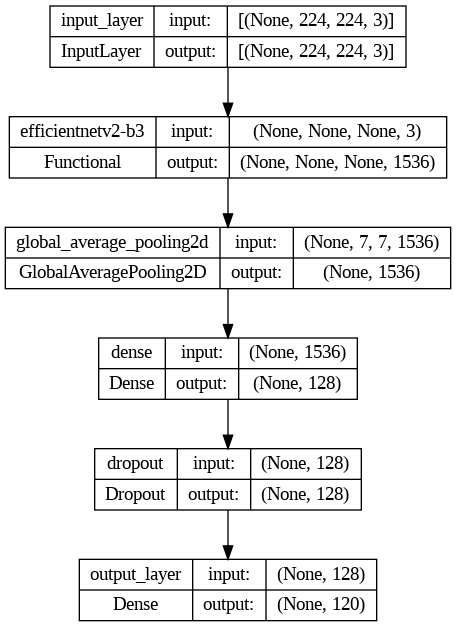

In [12]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture and save it as a PNG file
plot_model(model, to_file='model_architecture.png', show_shapes=True)

# Training

In [13]:
# Fit the model
history = model.fit(train_data,
                    validation_data=test_data,
                    validation_steps=int(0.20 * len(test_data)),
                    epochs=20,
                    steps_per_epoch=len(train_data),
                    callbacks=[checkpoint_callback, early_stopping_callback])

Epoch 1/30
375/375 [==============================] - ETA: 0s - loss: 1.6051 - accuracy: 0.7456
Epoch 1: val_loss improved from inf to 0.32385, saving model to model_checkpoint.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


375/375 [==============================] - 61s 110ms/step - loss: 1.6051 - accuracy: 0.7456 - val_loss: 0.3239 - val_accuracy: 0.9175
Epoch 2/30
375/375 [==============================] - ETA: 0s - loss: 0.3538 - accuracy: 0.9007
Epoch 2: val_loss improved from 0.32385 to 0.25072, saving model to model_checkpoint.h5
375/375 [==============================] - 41s 104ms/step - loss: 0.3538 - accuracy: 0.9007 - val_loss: 0.2507 - val_accuracy: 0.9245
Epoch 3/30
375/375 [==============================] - ETA: 0s - loss: 0.2729 - accuracy: 0.9167
Epoch 3: val_loss improved from 0.25072 to 0.23841, saving model to model_checkpoint.h5
375/375 [==============================] - 40s 102ms/step - loss: 0.2729 - accuracy: 0.9167 - val_loss: 0.2384 - val_accuracy: 0.9251
Epoch 4/30
375/375 [==============================] - ETA: 0s - loss: 0.2219 - accuracy: 0.9311
Epoch 4: val_loss improved from 0.23841 to 0.23702, saving model to model_checkpoint.h5
375/375 [==============================] - 41s

# Evaluating the Model

In [15]:
(test_loss, test_accuracy) = model.evaluate(test_data)
print('Test Loss: ', test_loss)
print('Test Accuracy: ', test_accuracy)

269/269 [==============================] - 24s 88ms/step - loss: 0.2440 - accuracy: 0.9231
Test Loss:  0.24397650361061096
Test Accuracy:  0.9230769276618958


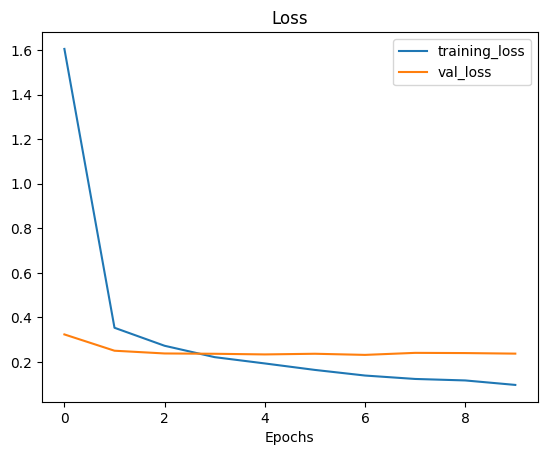

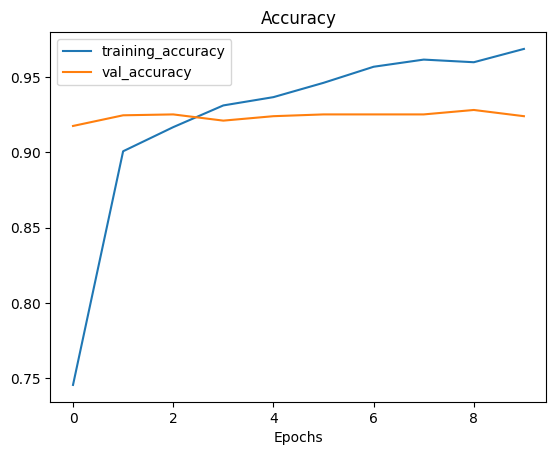

In [16]:
# Plot the validation and training data separately
import matplotlib.pyplot as plt


loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))

# Plot loss
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.legend()

# Plot accuracy
plt.figure()
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.legend();